<a href="https://colab.research.google.com/github/zain2864/Machine-Learning/blob/main/Predicting_Boston_Housing_Prices_Using_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets

from math import sqrt

# Linear Regression

In **linear regression**, the model maps a vector $x \in \mathbb{R}^d$ to a continuous label $\hat{y} \in \mathbb{R}$ using a learnable parameter $w \in \mathbb{R}^d$ by  
$$
w^\top x = w_1 x_1 + \cdots + w_d x_d 
$$
which is linear in $x$ (hence the name). More generally, for any *fixed* function $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^D$ ("feature function"), we can define a regression model $w \in \mathbb{R}^D$ that predicts  
$$
w^\top \phi(x) = w_1 \phi_1(x) + \cdots + w_D \phi_D(x) 
$$
which is still linear in $\phi(x)$ (but not necessarily in $x$!). Note that in this formulation, the model doesn't have any explicit bias parameter (i.e., a learnable scalar constant in $x$). But this is without loss of generality. We can always make $\phi_1(x) = 1$ for all $x$ so that $w_1 \in \mathbb{R}$ becomes the bias parameter.  

# Feature Function 

We can define the feature function $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^D$ however we want. A natural choice for regression is polynomial feature expansion. The function below implements the expansion using a list of degrees. For instance, if we pass $[0, 1, \ldots, m]$ as degrees with the original feature dimension $d$, the new representation has dimension $D = md+1$ as 
$$
\begin{align}
   x = \begin{bmatrix} x_1 \\ \vdots \\ x_d \end{bmatrix} \in \mathbb{R}^d
   &&\Longrightarrow&&
  \phi(x) = \begin{bmatrix} 1 \\ x_1 \\ \vdots \\ x_d \\ \vdots \\ x_1^m \\ \vdots \\ x_d^m \end{bmatrix} \in \mathbb{R}^{md + 1}
\end{align}  
$$
where when the degree 0 is passed we only add a single feature (constant 1) since anything to the power of 0 is 1. On the other hand, for each nonzero degree $p \neq 0$, we add $d$ new features $x_1^p \ldots x_d^p$ corresponding to the element-wise exponentiation by $p$. We will also calculate the empirical means $\mu \in \mathbb{R}^D$ and standard deviations $\sigma \in \mathbb{R}^D$ of features on the training inputs $x^{(1)} \ldots x^{(N)} \in \mathbb{R}^d$ *after the transform*, that is  
$$
\begin{align}
\mu_j &= \frac{1}{N} \sum_{i=1}^N \phi_j(x^{(i)}) &&\forall j = 1 \ldots D \\
\sigma_j &= \sqrt{\frac{1}{N-1} \sum_{i=1}^N (\phi_j(x^{(i)}) - \mu_j)^2} &&\forall j = 1 \ldots D
\end{align}
$$
and use them to normalize the training data (i.e., make the training data have mean zero and variance 1 *after the transform*) for numerical stability. We will use the same $\mu$ and $\sigma$ to normalize test data so that normalization is consistent between training and testing.    

In [ ]:
def polynomial_expansion(X, degrees, mu=None, sigma=None):
  """
    Input:
      X (N, d): Training data, each row is a d-dimensional input vector 
      degrees: List of degrees specifying the polynomial expansion
      mu (D,): Feature means for normalization
      sigma (D,): Feature standard deviations for normalization

    Output:
      X_new (N, D): Training data after expansion and normalization 
      mu (D,): See Input, if None is passed this is computed
      sigma (D,): See Input, if None is passsed this is computed
      X_new_unnormalized (N, D): Training data after expansion before normalization (for sanity check)
  """
  N, d = X.shape
    
  # Calculate the dimension of the transformed feature vector phi(x)
  D = (len(degrees) - 1) * d + 1 if 0 in degrees else len(degrees) * d
      
  X_new_unnormalized = np.empty([N, D])
  if 0 in degrees:
    X_new_unnormalized[:, 0] = 1
    column = 1
  else:
    column = 0  # Track current column position
      
  for degree in degrees:
    if degree != 0:
      new_features = X ** degree  # (N, d)
      X_new_unnormalized[:, column:column + d] = new_features  # Populate the next d columns              
      column += d

  # Normalize features (independently).
  if mu is None or sigma is None:
    mu = X_new_unnormalized.mean(0)
    sigma = X_new_unnormalized.std(0)
    sigma[sigma < 0.0001] = 1  # If the feature is constant, variance is zero. Avoid division by zero

  X_new = (X_new_unnormalized - mu) / sigma
  if 0 in degrees:
    X_new[:, 0] = 1  # We don't normalize the bias dimension.

  return X_new, mu, sigma, X_new_unnormalized

In [ ]:
# Sanity check
X = np.array([[2, 3], 
              [4, 5], 
              [-1, -8]])
degrees = (0, 1, 2)

X_new, mu, sigma, X_new_unnormalized = polynomial_expansion(X, degrees)

print('Original X')
print(X)
print('\nAfter expansion with degrees', degrees)
print(X_new_unnormalized)
print('\nFinal normalized version')
print(X_new)
print('\nFeature means after normalization')
print(np.round(X_new.mean(0), decimals=14))
print('\nFeature standard deviations after normalization')
print(X_new.std(0))

Original X
[[ 2  3]
 [ 4  5]
 [-1 -8]]

After expansion with degrees (0, 1, 2)
[[ 1.  2.  3.  4.  9.]
 [ 1.  4.  5. 16. 25.]
 [ 1. -1. -8.  1. 64.]]

Final normalized version
[[ 1.          0.16222142  0.52489066 -0.46291005 -1.0245833 ]
 [ 1.          1.13554995  0.87481777  1.38873015 -0.33190726]
 [ 1.         -1.29777137 -1.39970842 -0.9258201   1.35649056]]

Feature means after normalization
[ 1. -0.  0.  0.  0.]

Feature standard deviations after normalization
[0. 1. 1. 1. 1.]


# Least-Squares Estimate

Let $(x^{(1)}, y^{(1)}) \ldots (x^{(N)}, y^{(N)}) \in \mathbb{R}^d \times \mathbb{R}$ denote $N$ labeled examples for training a linear regression model and let $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^D$ denote the feature transform we will use. The **least-squares estimate** (LSE) for the labeled data is a model $w^*$ that achieves the smallest sum of squared errors (hence the name), that is
$$
w^* \in \operatorname*{argmin}_{w \in \mathbb{R}^D}\; \sum_{i=1}^N (y^{(i)} - w^\top \phi(x^{(i)}))^2 
$$
The square-root of the loss is called **root-mean-square error (RMSE)** (which is more interpretable since it brings the unit back down from squaring).
It is convenient to organize the training data as a data matrix $X \in \mathbb{R}^{N \times d}$ and a label vector $y \in \mathbb{R}^N$. We will also write $\phi(X) \in \mathbb{R}^{N \times D}$ to denote the data matrix under row-wise feature transform. We can then rewrite the LSE in a linear algebraic form:
$$
w^* \in \operatorname*{argmin}_{w \in \mathbb{R}^D}\; \| y - \phi(X) w\|^2
$$
We know that the unique solution is given by $w^* = \phi(X)^+ y$ where $\phi(X)^+ \in \mathbb{R}^{D \times N}$ is the [pseudo-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) of $\phi(X) \in \mathbb{R}^{N \times D}$. In the class we mostly assume that $\phi(X)$ is invertible (i.e., the feature columns are linearly independent, which is a reasonable assumption) in which case $\phi(X)^+ = (\phi(X)^\top \phi(X))^{-1} \phi(X)$, but the pseudo-inverse solution is true even if $X$ is not invertible (as long as nonzero). See [Appendix F of this note](http://karlstratos.com/notes/policy_gradient.pdf) if you want to see a proof. 


In [ ]:
class LinearRegressor:

  def __init__(self, X_train=None, y_train=None, degrees=(0, 1)):
    self.w = None  # Parameter
    self.mu = None  # Feature means (computed from training data)
    self.sigma = None  # Feature standard deviations (computed from training data)
    self.degrees = degrees

    # If given training data at initialization, compute the closed-form LSE.
    if X_train is not None and y_train is not None:
      X_train_new = self.feature_transform(X_train, train=True)
      self.w = np.dot(np.linalg.pinv(X_train_new), y_train) 

  def feature_transform(self, X, train=False):
    if train: 
      X_new, mu, sigma, _ = polynomial_expansion(X, self.degrees)
      self.mu = mu
      self.sigma = sigma
    else:
      assert self.mu is not None and self.sigma is not None
      X_new = polynomial_expansion(X, self.degrees, self.mu, self.sigma)[0]

    return X_new

  def predict(self, X):
    assert self.w is not None 
    X_new = self.feature_transform(X)
    preds = np.dot(X_new, self.w)
    return preds

  def squared_loss(self, X, y):
    preds = self.predict(X)
    errors = y - np.squeeze(preds) 
    squared_loss = np.mean(errors ** 2)  # Average squared difference
    return squared_loss    

# Synthetic Experiment



Before we work on a real dataset with a multi-dimensional input space, let's explore regression in 1-dimensional inputs, which is easy to visualize. We will do this with a <i>synthetic</i> data domain, where we simply generate the data from a noisy model.
Note that in this case, contrary to the real world scenario, we can ask how well the regression method recovers the true model; in the real world case this is of course not a meaningful question because we will never know the true model.

In [ ]:
class TrueModel:

  def __init__(self): 
    self.true_mapping = lambda x: np.sin(x * 1.7) + .1 * x ** 2 + 3
    self.true_standard_deviation = 0.3

  def sample(self, num_samples, left_end=-2, right_end=2):
    # Get evenly separated inputs then jitter 'em. 
    X_clean = np.linspace(left_end, right_end, num_samples)
    noise_x = np.random.uniform(-.1, .1, X_clean.shape)
    X = np.expand_dims(X_clean + noise_x, axis=1)
    
    # Generate labels according to the true model.
    y_clean = self.true_mapping(X)
    noise_y = np.random.normal(0, self.true_standard_deviation, y_clean.shape)
    y = np.squeeze(y_clean + noise_y)
    
    return X, y   

  def visualize_samples(self, num_samples, left_end=-2, right_end=2):
    X, y = self.sample(num_samples, left_end, right_end)
    plt.plot(X, y, 'r*')
    plt.xlabel('x')
    plt.ylabel('y')

    # Also plot the true mapping over dense x-axis ticks
    xticks = np.expand_dims(np.arange(left_end, right_end, 0.01), axis=1)
    plt.plot(xticks, self.true_mapping(xticks), 'r:')

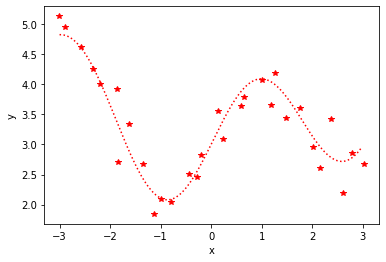

In [ ]:
true_model = TrueModel()
true_model.visualize_samples(30, -3, 3)

Let's train models with various degrees on samples from the true model. We expect that more complex models can fit the *training* data better. Visualization helps us understand why. 

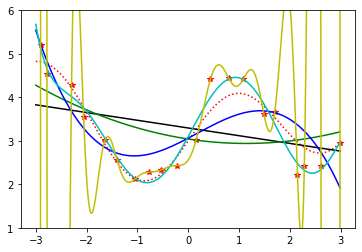

In [ ]:
X_train, y_train = true_model.sample(20, -3, 3)

model_linear = LinearRegressor(X_train, y_train, (0, 1))
model_quadratic = LinearRegressor(X_train, y_train, (0, 1, 2))
model_cubic = LinearRegressor(X_train, y_train, range(0, 4))
model_degree7 = LinearRegressor(X_train, y_train, range(0, 8))
model_degree20 = LinearRegressor(X_train, y_train, range(0, 21))

xticks = np.expand_dims(np.arange(-3, 3, 0.01), axis=1)
plt.plot(X_train, y_train, 'r*')
plt.plot(xticks, true_model.true_mapping(xticks), 'r:')
plt.plot(xticks, model_linear.predict(xticks), 'k-')
plt.plot(xticks, model_quadratic.predict(xticks), 'g-')
plt.plot(xticks, model_cubic.predict(xticks), 'b-')
plt.plot(xticks, model_degree7.predict(xticks), 'c-')
plt.plot(xticks, model_degree20.predict(xticks), 'y-')

plt.ylim(1,6);

This shows that more complex models can fit the *training* data better, but we can already see that they will not necessarily be better at handling unseen input values (i.e., they are **overfitted**). We can evaluate these models numerically, by computing training loss (avg. squared error) as well as the test loss. 

In [ ]:
X_test, y_test = true_model.sample(100, -3, 3)  # Same model, but new samples
max_degrees = [0, 1, 2, 3, 5, 7, 15, 25]

print('\t\tTrain loss\tTest loss\n')
for max_degree in max_degrees:
  model = LinearRegressor(X_train, y_train, range(0, max_degree + 1))
  loss_train = model.squared_loss(X_train, y_train)
  loss_test = model.squared_loss(X_test, y_test)
  print('Degree {:3d}:\t{:.4f}\t\t{:.4f}'.format(max_degree, loss_train, loss_test))

		Train loss	Test loss

Degree   0:	0.8952		0.7584
Degree   1:	0.7927		0.7122
Degree   2:	0.7416		0.6440
Degree   3:	0.3629		0.2731
Degree   5:	0.0770		0.1330
Degree   7:	0.0429		0.1575
Degree  15:	0.0111		6.1594
Degree  25:	0.0000		2981754.0320


So, as expected, more complex models reduce training squared loss, but at some point along the complexity axis, the test squared loss starts increasing, due to overfitting (this is also graphically evident in the plot, of course).

It would be interesting to see how this table would change if we had more training data than 20 training examples...

# Real Dataset: Boston Housing

We are now ready for some more realistic experiments. Let's consider the Boston Housing data set, originally from the UCI data repository. It's packaged with the scikit-learn distribution, so it's easy to load it. It's in a rather fancy format, containing in addition to the raw data a description explaining what the features are.

The task here is to predict median house prices (in circa 1980 dollars, so don't be shocked! :-) based on various measurements of the neighborhoods in Boston.

In [ ]:
boston_dataset = sklearn.datasets.load_boston()
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## Data split

We will first shuffle the data; to make sure everyone is working with the same partitions, we will fix the seed of the pseudorandom number generator.

In [ ]:
X_boston = boston_dataset.data  # Our data matrix
y_boston = boston_dataset.target  # Our label vector 

np.random.seed(54321)  # Because the data is so small, different data randomizations may yield greatly different results.
shuffled_row_indices = np.random.permutation(X_boston.shape[0])
X_boston = X_boston[shuffled_row_indices, :]
y_boston = y_boston[shuffled_row_indices]

It's a tiny dataset. Still, we need to partition the data into train, val, and test. Let's put approximately 70% in train, 15% in val, and 15% in test. Important: **DO NOT LOOK AT OR TOUCH THE TEST PORTION** until final evaluation. The test portion should be evaluated on *once* at the very end, after we're all done with model exploration and optimization based on training and validation portions.

In [ ]:
num_examples_total = X_boston.shape[0]
num_examples_train = int(num_examples_total * 0.7)
num_examples_val = int(num_examples_total * 0.15)
num_examples_test = num_examples_total - num_examples_train - num_examples_val

X_train = X_boston[0:num_examples_train, :]
y_train = y_boston[0:num_examples_train]
X_val = X_boston[num_examples_train:num_examples_train + num_examples_val, :]
y_val = y_boston[num_examples_train:num_examples_train + num_examples_val]
X_test = X_boston[num_examples_train + num_examples_val:, :]
y_test = y_boston[num_examples_train + num_examples_val:]

print('Num examples: {:d} train, {:d} validation, {:d} test'.format(num_examples_train, num_examples_val, num_examples_test))

Num examples: 354 train, 75 validation, 77 test


## Data Staring

Now that we have a data split, let's stare at data. In any machine learning task, it is essential to actually *look* at the raw data with our own eyes. Develop the habit of looking at data and model predictions yourself, rather than just reading or listening to what others say. 

In [ ]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('\nHouse:', list(np.round(X_train[0, :], 2)))  
print('\nPrice:', y_train[0])  # Median house price in $1,000s

X_train (354, 13)
y_train (354,)

House: [0.25, 0.0, 9.9, 0.0, 0.54, 5.7, 77.7, 3.94, 4.0, 304.0, 18.4, 396.42, 11.5]

Price: 16.2


Note that the raw feature values are in greatly different scales, so data normalization will be important. We may also visiualize the house price (y) as a function of a particular feature, for instance the average number of rooms per dwelling (6th feature). 

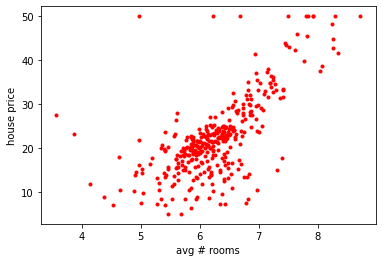

In [ ]:
plt.plot(X_train[:, 5], y_train, 'r.')
plt.xlabel('avg # rooms')
plt.ylabel('house price');

So the more rooms, the pricier (not surprisingly). On the other hand, the price should be lower if there's more crime (per capita crime rate by town, 1st feature).

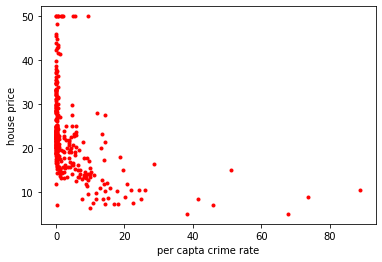

In [ ]:
plt.plot(X_train[:, 0], y_train, 'r.')
plt.xlabel('per capta crime rate')
plt.ylabel('house price');

## Training by Gradient Descent

The closed-form solution above is computationally convenient and useful for mathematical analysis, but 

1. It's specific to a particular loss (sum of squared errors) and model (linear regressor). In general, we won't have such a closed-form expression when we have different models/losses. 

2. Even in this case, it has issues with scalability. The solution involves taking the pseudo-inverse of $\phi(X) \in \mathbb{R}^{N \times D}$ which takes $O(N^2 D)$ time/memory (assuming $N \geq D$). The *quadratic* dependence on the number of example means we cannot compute this in a tractable amount of time/memory unless $N$ is tiny.

Thus we turn to **gradient descent**, a general method for optimizing any differentiable function. Unlike the closed-form solution, it's iterative: it starts from some initial parameter value and follows the negative gradient of the loss with respect to the parameter. Although doesn't yield the solution right away, if the loss is *convex* (as is the case here) it will eventually converge to an optimal solution (with a right step size). If the loss is not convex, there's no guarantee that it'll converge to the optimal solution, but it *will* converge to *some* locally optimal solution (which obviously depends on initialization).

## Gradient of the Squared Loss 

Given $X \in \mathbb{R}^{N \times d}$ (assume it's already feature transformed) and $y \in \mathbb{R}^N$, the (average) squared loss is a *function* $J: \mathbb{R}^d \rightarrow \mathbb{R}$ that maps a particular value of model parameter $w \in \mathbb{R}^d$ to its associated loss on the data:
$$
J(w) = \frac{1}{N} \| y - X w\|^2
$$
The **gradient** of $J$ (with respect to $w$, which is implied since we treat $J$ as a function of $w$) is also a *function*, denoted by $\nabla J: \mathbb{R}^d \rightarrow \mathbb{R}^d$, given by 
$$
\nabla J(w) = - \frac{2}{N} X^\top (y - X w)
$$
Make sure you can verify this yourself, either by reducing it to single-variable calculus and taking the partial derivative of $J(w)$ with respect to $w_j$ for $j = 1 \ldots d$, or using [matrix calculus](https://www.google.com/search?q=matrix+cookbook&oq=matrix+cookboo&aqs=chrome.0.0i512j69i57j0i512l3j0i22i30l2.1982j0j7&sourceid=chrome&ie=UTF-8). In every step of gradient descent, we compute the gradient of $J$ at the current value of $w \in \mathbb{R}^d$, which yields a vector of the same length $\nabla J(w) \in \mathbb{R}^d$ to be subtracted from $w$. 

In [ ]:
def squared_loss_and_gradient(X, y, w, no_grad=False):  # Expects X already feature transformed
  preds = np.dot(X, w)
  errors = y - np.squeeze(preds) 
  loss = np.mean(errors **2)
  if no_grad:
    return loss
  else: 
    grad = - 2 * np.mean(X * np.expand_dims(errors, axis=1), axis=0)
    return loss, grad.reshape(w.shape)

## Gradient Descent Algorithm

Let's define a general-ish gradient descent routine. In general, gradient descent has various optimization-related "hyperparameters" that we may tune to make training more effective. But we'll keep things simple and stick with the most basic version: constant learning rate and early stopping based on validation loss.

In [ ]:
def gradient_descent(model, X_train, y_train, loss_and_gradient, X_val=None, y_val=None, lr=0.01, num_steps_max=10000, patience=10):
  X_train_new = model.feature_transform(X_train, train=True)  
  has_val = X_val is not None and y_val is not None
  if has_val:
    X_val_new = model.feature_transform(X_val)
  model.w = np.zeros((X_train_new.shape[1]))  # Parameter initialized as a zero vector
  losses = []  # Let's keep track of training loss
  loss_val_best = float('inf')
  death_count = 0

  for t in range(num_steps_max):
    loss, grad = loss_and_gradient(X_train_new, y_train, model.w)  # Generic function that returns loss/gradient at current w 
    losses.append(loss)
        
    
    # (1) Implement the gradient-based update of model.w. 
    model.w = model.w - lr*grad
    # (2) Early stop if converged. One way to do this is as follows (if we have validation data). 
    #     Check if the validation loss is better than previous best. 
    #     If so, reset death_count to zero. If not, increase it by 1, and if it goes over patience call break. 

    loss_val = loss_and_gradient(X_val_new, y_val, model.w, no_grad=True)
    if loss_val < loss_val_best :
      loss_val_best = loss_val
      death_count = 0

    if death_count > patience :
      break

    else :
      death_count = death_count + 1

    #raise NotImplementedError

  # Compute training loss and validation loss of the trained model
  loss_train = loss_and_gradient(X_train_new, y_train, model.w, no_grad=True)
  loss_val = loss_and_gradient(X_val_new, y_val, model.w, no_grad=True) if has_val else None

  return losses, loss_train, loss_val

You should be able to train a linear model with the code below; you can compare it to the closed form solution to make sure you get similar results.

Gradient descent [1812 iter]: train RMSE 4.7747, val RMSE 4.8719
Exact solution: train RMSE 4.7733, val RMSE 4.8748


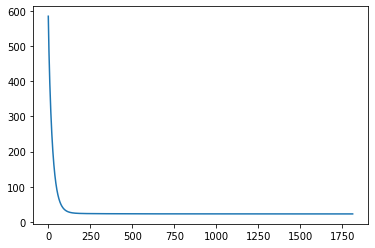

In [ ]:
model = LinearRegressor(degrees=(0, 1))

# Training 
losses, loss_train, loss_val = gradient_descent(model, X_train, y_train, squared_loss_and_gradient, X_val, y_val, lr=0.01, num_steps_max=10000)  # Try changing lr and num steps
print('Gradient descent [{:d} iter]: train RMSE {:.4f}, val RMSE {:.4f}'.format(len(losses), sqrt(loss_train), sqrt(loss_val)))

# Plot the loss value over iterations, to observe the optimization process
plt.plot(losses);

# Compare with the optimal loss
model_exact = LinearRegressor(X_train, y_train, degrees=(0, 1))
loss_exact_train = model_exact.squared_loss(X_train, y_train)
loss_exact_val = model_exact.squared_loss(X_val, y_val)
print('Exact solution: train RMSE {:.4f}, val RMSE {:.4f}'.format(sqrt(loss_exact_train), sqrt(loss_exact_val)))


Now we can explore some more feature spaces and do **model selection** based on validation loss.

In [ ]:
feature_sets = [(0,), (0, 1), (0, 1, 2), (0, 1, 2, 3)]  # Try others!

best_loss_val = float('inf')
best_model = None
for feature_set in feature_sets:
  model = LinearRegressor(degrees=feature_set)
  losses, loss_train, loss_val = gradient_descent(model, X_train, y_train, squared_loss_and_gradient, X_val, y_val)
  print('Model {:s}: {:d} iterations, train RMSE {:.4f}, val RMSE {:.4f}'.format(str(feature_set), len(losses), sqrt(loss_train), sqrt(loss_val)))
  if loss_val < best_loss_val:
    best_loss_val = loss_val
    best_model = model

print('-' * 79)
print('Best performing model is {:s} with val RMSE {:.4f}'.format(str(best_model.degrees), sqrt(best_loss_val)))

Model (0,): 1611 iterations, train RMSE 9.0911, val RMSE 9.8558
Model (0, 1): 1812 iterations, train RMSE 4.7747, val RMSE 4.8719
Model (0, 1, 2): 2330 iterations, train RMSE 3.9824, val RMSE 4.7008
Model (0, 1, 2, 3): 918 iterations, train RMSE 3.9487, val RMSE 4.8508
-------------------------------------------------------------------------------
Best performing model is (0, 1, 2) with val RMSE 4.7008


## Asymmetric Squared Loss

The generality of gradient descent allows us to optimize *any* loss as long as we can compute the gradient with respect to the model parmameter. Let's consider an asymmetric loss $l_\alpha: \mathbb{R} \times \mathbb{R} \rightarrow [0, \infty)$:
$$
l_\alpha(\hat{y}, y) = \left\{ \begin{array}{rl}
  \alpha (\hat{y} - y)^2 &\mbox{ if $\hat{y}<y$} \\
  (\hat{y} - y)^2 &\mbox{ otherwise}
       \end{array} \right.
$$
where $\alpha \geq 0$ is an additional hyperparameter specifying the relative weight of the loss on underestimating predictions.


In [ ]:
def asymmetric_squared_loss_and_gradient(X, y, w, no_grad=False, alpha=0.05):  # Expects X already feature transformed
  Implement. You should be able to copy and paste the code from squared_loss_and_gradient and modify it only a little bit. 
   preds = np.dot(X, w)
   errors = y - np.squeeze(preds) 
   e_k = errors
   s = 0
   for x in range(len(errors)) :
    if preds[x] < y[x]  :
      s = s + alpha*(errors[x]**2)
      e_k[x]= alpha*errors[x]
    else :
      s = s + (errors[x]**2)
 # loss = np.mean(errors **2)
    loss = s/len(errors)
    if no_grad:
      return loss
    else: 
      grad = - 2 * np.mean(X * np.expand_dims(errors, axis=1), axis=0)
    return loss, grad.reshape(w.shape)

  #raise NotImplementedError

In [ ]:
# For convenience, we will define this lambda expression so we could call it inside GD without passing alpha to GD.
def aloss(alpha):
    return lambda X, y, w, no_grad=False: asymmetric_squared_loss_and_gradient(X, y, w, no_grad=no_grad, alpha=alpha)

We can now train a linear regressor to optimize this asymmetric loss. The only change in the code is passing a different function to calculate the loss and gradient in the gradient descent algorithm. We'll do similar model selection based on the validation loss (which is the new asymmetric loss, not squared loss!).

In [ ]:
alpha = 0.05  # We will penalize underestimation of housing prices by only 5% of the penalty for overestimation. 

best_loss_val_asym = float('inf')
best_model_asym = None
Do model selection using the same feature sets you used for the symmetric loss. 
# You should be able to copy and paste the model selection code from before and modify it only a little bit. 


feature_sets = [(0,), (0, 1), (0, 1, 2), (0, 1, 2, 3)]
for feature_set in feature_sets:
  model = LinearRegressor(degrees=feature_set)
  losses, loss_train, loss_val = gradient_descent(model, X_train, y_train, aloss(alpha), X_val, y_val)
  print('Model {:s}: {:d} iterations, train RMSE {:.4f}, val RMSE {:.4f}'.format(str(feature_set), len(losses), sqrt(loss_train), sqrt(loss_val)))
  if loss_val < best_loss_val_asym:
    best_loss_val_asym = loss_val
    best_model_asym = model

  #else 

#raise NotImplementedError

print('-' * 79)
print('Best performing model is {:s} with val RASE {:.4f}'.format(str(best_model_asym.degrees), sqrt(best_loss_val_asym)))

Model (0,): 1647 iterations, train RMSE 0.3298, val RMSE 0.1729
Model (0, 1): 148 iterations, train RMSE 0.1755, val RMSE 0.0345
Model (0, 1, 2): 144 iterations, train RMSE 0.1608, val RMSE 0.0367
Model (0, 1, 2, 3): 150 iterations, train RMSE 0.1537, val RMSE 0.0316
-------------------------------------------------------------------------------
Best performing model is (0, 1, 2, 3) with val RASE 0.0316


## Final Evaluation

Now that we have done model selection for both the regular squared loss and the new asymmetric loss, we can do final evaluation on the test portion. 

In [ ]:
#  Implement final evaluation by computing sym/asym loss on best sym/asym models. Be careful to use the correct feature transform for each model.
symmetric_t = best_model.feature_transform(X_test, train=False)
asymmetric_t = best_model_asym.feature_transform(X_test, train=False)

test_loss_sym_model_sym = sqrt(squared_loss_and_gradient(symmetric_t, y_test, best_model.w, no_grad= True))


test_loss_sym_model_asym = sqrt(squared_loss_and_gradient(asymmetric_t, y_test, best_model_asym.w, no_grad= True))


test_loss_asym_model_sym = sqrt(asymmetric_squared_loss_and_gradient(symmetric_t, y_test, best_model.w, no_grad=True)) 


test_loss_asym_model_asym = sqrt(asymmetric_squared_loss_and_gradient(asymmetric_t, y_test, best_model_asym.w, no_grad=True)) 


print('TEST RESULTS')
print('                Sym loss | Asym loss')
print('___________________________________')
print('Sym model       {:.4f}  |  {:.4f}'.format(test_loss_sym_model_sym, test_loss_asym_model_sym))
print('Asym model      {:.4f}  |  {:.4f}'.format(test_loss_sym_model_asym, test_loss_asym_model_asym))

TEST RESULTS
                Sym loss | Asym loss
___________________________________
Sym model       3.4334  |  0.1827
Asym model      4.1187  |  0.1750


What can we conclude from this comparison? Which model is "better", and in what sense? 

 

Using this comparison, it seems that symmetric model is better due to having a large difference in symmetric losses between both models. For Asymmetric loss, it is not that different for both models, however, since they are very close in magnitude, while for symmetric losses they are not, we choose the symmetric model.  